In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import torch
import torch_geometric
from torch_geometric.loader import DataLoader
from torch_geometric.nn import summary
import xarray as xr
import yaml

import Dataset
import Models
from utils import time_func

In [2]:
print(f"Torch version: {torch.__version__}")
print(f"Cuda available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"Cuda device: {torch.cuda.get_device_name()}")
print(f"Cuda version: {torch.version.cuda}")
print(f"Torch geometric version: {torch_geometric.__version__}")

Torch version: 2.0.1+cu117
Cuda available: False
Cuda version: 11.7
Torch geometric version: 2.3.1


In [3]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
DEVICE

device(type='cpu')

In [4]:
params = yaml.safe_load(open('./config/pipeline.yaml'))

DATA_PATH = params['input_subset_pre_processed']
MESH_PATH = params['input_subset_grid']

TRAIN_PROP = params['train_prop']
VAL_PROP = params['val_prop']
TEST_PROP = params['test_prop']

TRAIN_BATCH_SIZE = params['train_batch_size']
VAL_BATCH_SIZE = params['val_batch_size']
TEST_BATCH_SIZE = params['test_batch_size']

N_FEATURES = params['n_features']
HID_CHANNELS = params['hid_channels']
N_CLASSES = params['n_classes']

FINAL_ACT = None
if params['final_act'] == "sigmoid":
    FINAL_ACT = torch.sigmoid
elif params['final_act'] == "linear":
    FINAL_ACT = torch.nn.Linear(1, 1)

LOSS_OP = None
if params['loss_op'] == "CE":
    LOSS_OP = torch.nn.CrossEntropyLoss()

OPTIMIZER = None
if params['optimizer'] == "Adam":
    OPTIMIZER = torch.optim.Adam

LEARN_RATE = params['learn_rate']

PLOT_SHOW = params['plot_show']
PLOT_FOLDER = params['output_images_path']

# TODO this
PLOT_VERTICAL = params['plot_vertical']

TIMESTAMP = time_func.start_time()

### Dataset creation

In [5]:
timestamp = time_func.start_time()
train_dataset = Dataset.EddyDataset(root=DATA_PATH, mesh_path=MESH_PATH, split='train')
val_dataset = Dataset.EddyDataset(root=DATA_PATH, mesh_path=MESH_PATH, split='val')
test_dataset = Dataset.EddyDataset(root=DATA_PATH, mesh_path=MESH_PATH, split='test')
time_func.stop_time(timestamp, "Datasets creation")

    Shape of node feature matrix: torch.Size([757747, 1])
    Shape of graph connectivity in COO format: torch.Size([2, 4537526])
    Shape of labels: torch.Size([757747])
  ---  Datasets creation  ---  2.473 seconds.


In [6]:
print(train_dataset.len(), val_dataset.len(), test_dataset.len())

32 16 16


In [7]:
#val_dataset[25]

### Testing some parameters and orientation of graph edges

In [8]:
if (TRAIN_PROP+VAL_PROP+TEST_PROP) != 100:
    raise ValueError(f"Sum of train-val-test proportions with value {TRAIN_PROP+VAL_PROP+TEST_PROP} is different from 1")

if FINAL_ACT == None:
    raise ValueError(f"Parameter 'final_act' is invalid with value {params['final_act']}")

if LOSS_OP == None:
    raise ValueError(f"Parameter 'loss_op' is invalid with value {params['loss_op']}")

if OPTIMIZER == None:
    raise ValueError(f"Parameter 'optimizer' is invalid with value {params['optimizer']}")

dummy_graph = train_dataset[0]

if dummy_graph.num_features != N_FEATURES:
    raise ValueError(f"Graph num_features is different from parameter N_FEATURES: ({dummy_graph.num_features} != {N_FEATURES})")

if dummy_graph.is_directed():
    raise ValueError("Graph edges are directed!")

### Train-validation-test split

In [9]:
train_loader = DataLoader(train_dataset, batch_size=TRAIN_BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=VAL_BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=TEST_BATCH_SIZE, shuffle=False)

print(len(train_loader.dataset), len(val_loader.dataset), len(test_loader.dataset))

32 16 16


### Model instantiation

In [10]:
Model = Models.GUNet

model = Model(
    in_channels = N_FEATURES,
    hidden_channels = HID_CHANNELS,
    out_channels = N_CLASSES,
    num_nodes = dummy_graph.num_nodes,   # TODO can put these in Dataset.py
    final_act = FINAL_ACT
).to(DEVICE)

model

GUNet instantiated!
	Middle act: relu
	Final act: torch


GUNet(
  (unet): GraphUNet(1, 32, 3, depth=3, pool_ratios=[0.002639403389257892, 0.5, 0.5])
)

In [11]:
if torch.cuda.is_available():
    #print("torch.cuda.memory_allocated: %fGB"%(torch.cuda.memory_allocated(0)/1024/1024/1024))
    #print("torch.cuda.memory_reserved: %fGB"%(torch.cuda.memory_reserved(0)/1024/1024/1024))
    #print("torch.cuda.max_memory_reserved: %fGB"%(torch.cuda.max_memory_reserved(0)/1024/1024/1024))
    print(torch.cuda.memory_summary())
else:
    print(summary(model, dummy_graph))

/home/b/b382485/miniconda3/envs/eddy-tracking/lib/python3.8/site-packages/torch_sparse/matmul.py:97: UserWarning: Sparse CSR tensor support is in beta state. If you miss a functionality in the sparse tensor support, please submit a feature request to https://github.com/pytorch/pytorch/issues. (Triggered internally at ../aten/src/ATen/SparseCsrTensorImpl.cpp:54.)
  C = torch.sparse.mm(A, B)


+-------------------------------+---------------------------------------------------+-------------------------------------------------------+----------+
| Layer                         | Input Shape                                       | Output Shape                                          | #Param   |
|-------------------------------+---------------------------------------------------+-------------------------------------------------------+----------|
| GUNet                         | [757747, 757747]                                  | [757747, 3]                                           | 5,539    |
| ├─(unet)GraphUNet             | [757747, 1], [2, 4537526]                         | [757747, 3]                                           | 5,539    |
| │    └─(down_convs)ModuleList | --                                                | --                                                    | 3,232    |
| │    │    └─(0)GCNConv        | [757747, 1], [2, 4537526], [4537526]            

### Optimizer

In [12]:
OPTIMIZER = OPTIMIZER(model.parameters(), lr=LEARN_RATE)

### Train function

In [13]:
def train():
    model.train()
    total_loss = 0

    for batch in train_loader:
        batch = batch.to(DEVICE)

        # zero the parameter gradients
        OPTIMIZER.zero_grad()

        # forward + loss
        pred = model(batch)
        loss = LOSS_OP(pred, batch.y)

        # If you try the Soft Dice Score, use this(even if the loss stays constant)
        #loss.requires_grad = True
        #loss = torch.tensor(loss.item(), requires_grad=True)

        # loss * _train_batch_size(32)
        total_loss += loss.item() * batch.num_graphs
        
        # backward + optimize
        loss.backward()
        OPTIMIZER.step()

    # average loss = total_loss / training graps(256)
    average_loss = total_loss / len(train_loader.dataset)
    return average_loss

### Evaluation function

In [14]:
@torch.no_grad()
def evaluate(loader):
    model.eval()
    total_loss = 0

    for batch in loader:
        batch = batch.to(DEVICE)

        # forward + loss
        pred = model(batch)
        loss = LOSS_OP(pred, batch.y)

        total_loss += loss.item() * batch.num_graphs
    
    average_loss = total_loss / len(loader.dataset)
    return average_loss

### Computation time check

In [15]:
time_func.stop_time(TIMESTAMP, "Computation before training finished!")

  ---  Computation before training finished!  ---  7.436 seconds.


### Epoch training, validation and testing

In [16]:
timestamp = time_func.start_time()

train_loss = []
valid_loss = []

for epoch in range(20):
    t_loss = train()
    v_loss = evaluate(val_loader)
    print(f'Epoch: {epoch+1:03d}, Train running loss: {t_loss:.4f}, Val running loss: {v_loss:.4f}')
    train_loss.append(t_loss)
    valid_loss.append(v_loss)

time_func.stop_time(timestamp, "Training Complete!")

metric = evaluate(test_loader)
print(f'Metric for test: {metric:.4f}')

Epoch: 001, Train running loss: 1.0980, Val running loss: 1.0943
Epoch: 002, Train running loss: 1.0943, Val running loss: 1.0908
Epoch: 003, Train running loss: 1.0906, Val running loss: 1.0870
Epoch: 004, Train running loss: 1.0867, Val running loss: 1.0830
Epoch: 005, Train running loss: 1.0826, Val running loss: 1.0787
Epoch: 006, Train running loss: 1.0782, Val running loss: 1.0737
Epoch: 007, Train running loss: 1.0736, Val running loss: 1.0681
Epoch: 008, Train running loss: 1.0686, Val running loss: 1.0622
Epoch: 009, Train running loss: 1.0632, Val running loss: 1.0567
Epoch: 010, Train running loss: 1.0578, Val running loss: 1.0511
Epoch: 011, Train running loss: 1.0522, Val running loss: 1.0453
Epoch: 012, Train running loss: 1.0464, Val running loss: 1.0392
Epoch: 013, Train running loss: 1.0402, Val running loss: 1.0329
Epoch: 014, Train running loss: 1.0339, Val running loss: 1.0252
Epoch: 015, Train running loss: 1.0273, Val running loss: 1.0183
Epoch: 016, Train running

### Comparison plot for train/validation loss

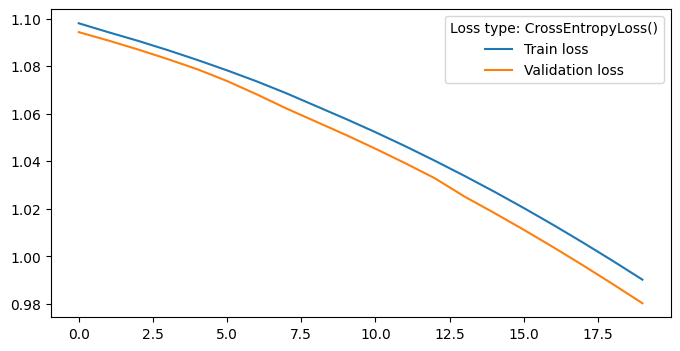

In [23]:
plt.figure(figsize=(8, 4))
plt.plot(train_loss, label='Train loss')
plt.plot(valid_loss, label='Validation loss')
plt.legend(title="Loss type: " + str(LOSS_OP))

if PLOT_SHOW:
    plt.show()
else:
    plt.savefig(PLOT_FOLDER+"/train_val_losses.png")
    plt.close()

### Graphical comparison model prediction/ground truth

In [24]:
torch.no_grad()
model.eval()
batch = next(iter(test_loader))
batch = batch.to(DEVICE)
pred = model(batch)
pred

tensor([[0.5890, 0.3717, 0.3834],
        [0.5933, 0.3634, 0.3769],
        [0.5934, 0.3623, 0.3764],
        ...,
        [0.6156, 0.4197, 0.3700],
        [0.6045, 0.4266, 0.3828],
        [0.6057, 0.4258, 0.3814]], grad_fn=<SigmoidBackward0>)

In [25]:
mesh = xr.open_dataset(MESH_PATH)
mesh_lon = mesh.lon[mesh.nodes].values
mesh_lat = mesh.lat[mesh.nodes].values

In [28]:
this_target = batch.y[:mesh.dims['nodes_subset']]
this_pred = []
for p in pred[:mesh.dims['nodes_subset']]:
    if p[0] > p[1] and p[0] > p[2]:
        this_pred.append(0)
    if p[1] > p[0] and p[1] > p[2]:
        this_pred.append(1)
    if p[2] > p[0] and p[2] > p[1]:
        this_pred.append(2)

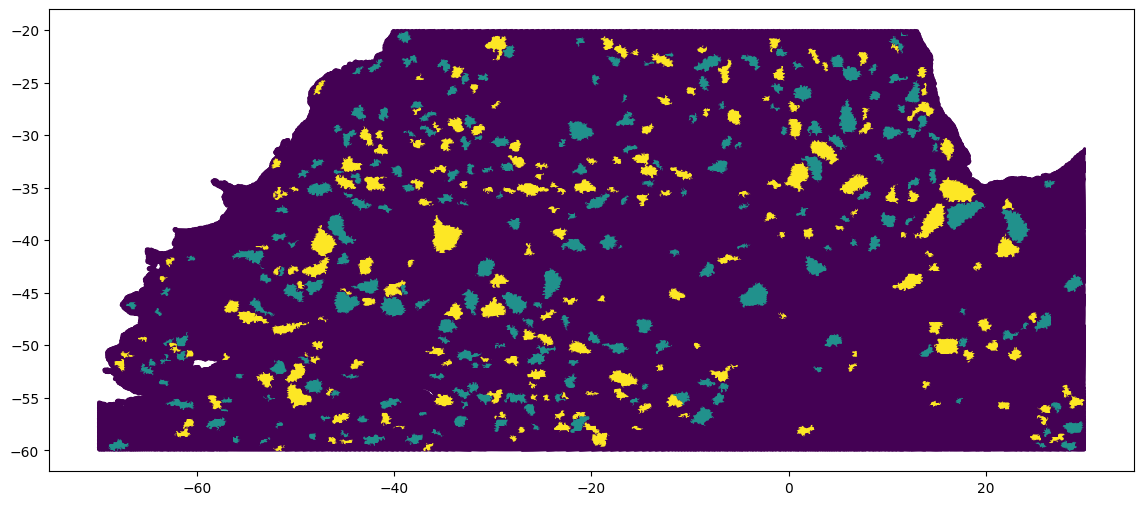

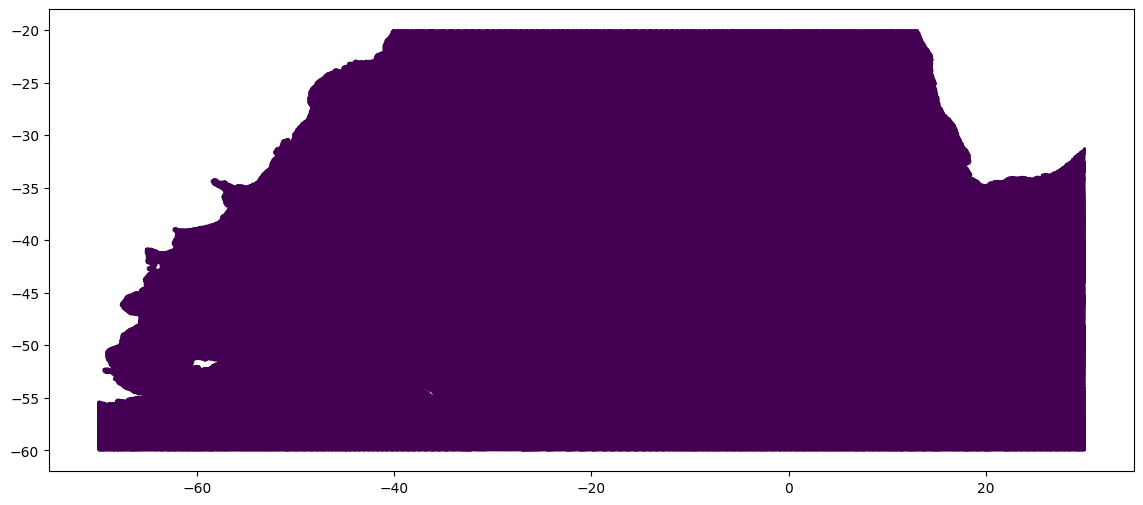

In [27]:
plt.figure(figsize=(14, 6))
plt.scatter(mesh_lon, mesh_lat, c=this_target, s=1)

plt.figure(figsize=(14, 6))
plt.scatter(mesh_lon, mesh_lat, c=this_pred, s=1)

plt.show()